In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb   
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler,RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import pickle


In [4]:
!pipreqs .

In [1]:
import sklearn
print(sklearn.__version__)

1.0.2


In [5]:
!pip install --upgrade pip

In [6]:
!pipreqs

Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in g:\Machine_learning\Final_Project\Bank_Marketing\requirements.txt


Reading Data Cleaned

In [3]:
df = pd.read_csv('Bank_Marketing_Cleaned.csv')
df.head()

,age,job,marital,education,balance,housing,loan,last_contact_day,month,duration,campaign,deposit
0,55,management,married,primary,3293,0,0,30,jul,64,2,0
1,24,blue-collar,single,secondary,167,0,1,18,feb,134,2,1
2,50,technician,divorced,secondary,0,0,0,13,aug,114,2,0
3,59,retired,divorced,tertiary,3444,0,0,6,feb,241,2,1
4,28,admin.,single,secondary,707,1,0,25,may,226,1,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44923 entries, 0 to 44922
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               44923 non-null  int64 
 1   job               44923 non-null  object
 2   marital           44923 non-null  object
 3   education         44923 non-null  object
 4   balance           44923 non-null  int64 
 5   housing           44923 non-null  int64 
 6   loan              44923 non-null  int64 
 7   last_contact_day  44923 non-null  int64 
 8   month             44923 non-null  object
 9   duration          44923 non-null  int64 
 10  campaign          44923 non-null  int64 
 11  deposit           44923 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 4.1+ MB


Splitting Data into Train and Test

In [4]:
X = df.drop('deposit', axis=1)
y = df['deposit']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

Preprocessing

In [6]:
num_cols = ['age', 'balance', 'last_contact_day', 'duration', 'campaign']
cat_cols = ['job', 'marital', 'month','loan','housing']
Bin_Cols = ['loan','housing']

In [7]:
# Ordinal feature
ordinal_cols = ['education']
education_order = ['primary', 'secondary', 'tertiary']


In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse=False), cat_cols),
        ('edu', OrdinalEncoder(categories=[education_order]), ordinal_cols)
       
    ],remainder='passthrough')
    


In [9]:
X_train_prep = preprocessor.fit_transform(X_train)

In [10]:
num_feature_names = num_cols
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
ord_feature_names = [f"{col}_encoded" for col in ordinal_cols]
all_feature_names = num_feature_names + list(cat_feature_names) + ord_feature_names


In [11]:
X_test_prep = preprocessor.transform(X_test)
X_test_prep_df = pd.DataFrame(X_test_prep, columns=all_feature_names)

In [14]:
X_test_prep_df.head()

,age,balance,last_contact_day,duration,campaign,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_mar,month_may,month_nov,month_oct,month_sep,loan_0,loan_1,housing_0,housing_1,education_encoded
0,0.800000,1.535874,-0.307692,-0.381395,1.5,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.133333,2.549327,0.230769,2.218605,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,0.200000,-0.896114,-1.076923,0.613953,-0.5,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,0.866667,2.090433,-0.230769,-0.348837,-0.5,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,1.266667,3.308670,-0.153846,-0.218605,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


Handling imbalance

Take top 3 models and try them on other imbalance methods to determine best method

Top 3 are Random forest classifier ,AdaboostClassifier and XGboost Classifier

wil use mix between undersampling and SMOTE

In [13]:
rus = RandomUnderSampler(sampling_strategy=0.5)
X_train_under,y_train_under  = rus.fit_resample(X_train_prep, y_train)
y_train_under.value_counts()


0    8408
1    4204
Name: deposit, dtype: int64

In [14]:
smote = SMOTE(sampling_strategy=0.8)
X_train_mix, y_train_mix = smote.fit_resample(X_train_under, y_train_under)
X_train_mix_df = pd.DataFrame(X_train_mix, columns=all_feature_names)
y_train_mix.value_counts()

0    8408
1    6726
Name: deposit, dtype: int64

In [15]:
model = RandomForestClassifier(random_state=42)
scores = cross_val_score(model, X_train_mix, y_train_mix, cv=5, scoring='accuracy')
print(scores)
print(scores.mean())

[0.84704328 0.8410968  0.83448959 0.89494549 0.90879048]
0.8652731278812344


In [18]:
model = XGBClassifier(random_state=42)
scores = cross_val_score(model, X_train_mix, y_train_mix, cv=5, scoring='accuracy')
print(scores)
print(scores.mean())

[0.83481995 0.83647175 0.83052527 0.89924017 0.9150694 ]
0.8632253101683875


In [19]:
model = AdaBoostClassifier(random_state=42)
scores = cross_val_score(model, X_train_mix, y_train_mix, cv=5, scoring='accuracy')
print(scores)
print(scores.mean())

[0.79814998 0.80145358 0.79649818 0.85563264 0.86682089]
0.8237110552286527


Random Under Sampling

In [20]:
rus = RandomUnderSampler(sampling_strategy=0.5)
X_train_under,y_train_under  = rus.fit_resample(X_train_prep, y_train)
X_train_under_df = pd.DataFrame(X_train_under, columns=all_feature_names)
y_train_under.value_counts()

0    8408
1    4204
Name: deposit, dtype: int64

Random Forest Classifier

In [101]:
model = RandomForestClassifier()
scores = cross_val_score(model, X_train_under, y_train_under, cv=5, scoring='accuracy')
print('scores:', scores)
print('mean score:', scores.mean())

scores: [0.80578676 0.80539041 0.81284695 0.80927835 0.79500397]
mean score: 0.8056612865051518


XGBoost Classifier

In [102]:
model = XGBClassifier()
scores = cross_val_score(model, X_train_under, y_train_under, cv=5, scoring='accuracy')
print('scores:', scores)
print('mean score:', scores.mean())

scores: [0.81093936 0.8045977  0.80293418 0.80333069 0.79896907]
mean score: 0.8041542000746187


AdaBoost Classifier

In [103]:
model = AdaBoostClassifier()
scores = cross_val_score(model, X_train_under, y_train_under, cv=5, scoring='accuracy')
print('scores:', scores)
print('mean score:', scores.mean())


scores: [0.79706698 0.80618312 0.79698652 0.80095163 0.78429818]
mean score: 0.7970972838938074


OverSmapling(Smote)

In [12]:
smote = SMOTE(sampling_strategy=0.99)
X_train_smoten,y_train_smoten  = smote.fit_resample(X_train_prep, y_train)
X_train_smoten_df = pd.DataFrame(X_train_smoten, columns=all_feature_names)
y_train_smoten.value_counts()

0    31734
1    31416
Name: deposit, dtype: int64

Random forest Classifier

In [22]:
model = RandomForestClassifier()
scores = cross_val_score(model, X_train_smoten, y_train_smoten, cv=5, scoring='accuracy')
print('scores:', scores)
print('mean score:', scores.mean())

scores: [0.88186857 0.95645289 0.9608076  0.96326207 0.95938242]
mean score: 0.9443547110055424


XGBoost Classifier

In [159]:
model = XGBClassifier()
scores = cross_val_score(model, X_train_smoten, y_train_smoten, cv=5, scoring='accuracy')
print('scores:', scores)
print('mean score:', scores.mean())

scores: [0.6935867  0.96785432 0.96761679 0.97212985 0.96872526]
mean score: 0.9139825811559777


Adaboost Classifer

In [160]:
model = AdaBoostClassifier()
scores = cross_val_score(model, X_train_smoten, y_train_smoten, cv=5, scoring='accuracy')
print('scores:', scores)
print('mean score:', scores.mean())

scores: [0.80364212 0.87537609 0.88202692 0.89105305 0.88131433]
mean score: 0.8666825019794141


There is significant improvement using smoten only

Now use grid search for Hyperparameter tuning

Randomm Forest Classifier

In [24]:
grid_param = { 
    'n_estimators': [50,100],
    'max_depth' : [20, 30, 40],
    'min_samples_split': [2],
    'max_features': ['sqrt', 'log2'],
}
grid_search = GridSearchCV(RandomForestClassifier(), grid_param, cv=5,scoring='accuracy')
grid_search.fit(X_train_smoten, y_train_smoten)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 40, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
0.9454315122723674


In [162]:
grid_param = { 
    'n_estimators': [200],
    'max_depth' : [70,80,90],
    'min_samples_split': [2, 4],
}
grid_search = GridSearchCV(RandomForestClassifier(), grid_param, cv=5,scoring='accuracy')
grid_search.fit(X_train_smoten, y_train_smoten)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 80, 'min_samples_split': 2, 'n_estimators': 200}
0.944418052256532


XGboost Classifier

In [62]:
grid_param = {
    'n_estimators': [100,],
    'max_depth': [10,20,30],
    'learning_rate': [0.01, 0.1, 0.2]
  
}
grid_search = GridSearchCV(XGBClassifier(), grid_param, cv=5,scoring='accuracy')
grid_search.fit(X_train_smoten, y_train_smoten)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 100}
0.9270741433670702


In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

As we have seen random forest was the best, Now before going on we have to check overfitting




In [14]:
model = RandomForestClassifier(n_estimators=200, max_depth=80, min_samples_split=2)
scores = cross_val_score(model, X_train_smoten, y_train_smoten, cv=5, scoring='accuracy')
y_train_pridict = model.fit(X_train_smoten, y_train_smoten).predict(X_train_smoten)
print('validation score:', scores.mean())
print('train score:', accuracy_score(y_train_smoten, y_train_pridict))


validation score: 0.9441488519398259
train score: 1.0


So as shown here for sure there is overfitting we will try to handle it 

let's change in some parameters and some

In [15]:
model = RandomForestClassifier(class_weight='balanced',n_estimators=40, max_depth=15, min_samples_split=6,max_features='log2',bootstrap=True,max_samples=0.1)
scores = cross_val_score(model, X_train_smoten, y_train_smoten, cv=5, scoring='accuracy')
y_train_pridict = model.fit(X_train_smoten, y_train_smoten).predict(X_train_smoten)
print('validation score:', scores.mean())
print('train score:', accuracy_score(y_train_smoten, y_train_pridict))


validation score: 0.8918131433095804
train score: 0.9081868566904197


Now the overfitting is less than before 
we did that after searching on each parameter we have used before and figured out that there are some parameters in random forest classifier leeds to overfitting like (max_depth,min sample split and n_estimators)
and after searching also found out that there are others reduce overfitting like (max_features,bootstrap and max_samples )

In [19]:
model = RandomForestClassifier(class_weight='balanced',n_estimators=40, max_depth=15, min_samples_split=6,max_features='log2',bootstrap=True,max_samples=0.1)
model.fit(X_train_smoten, y_train_smoten)
y_pred = model.predict(X_test_prep)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 0.8500834724540901
Confusion Matrix:
[[6864 1070]
 [ 277  774]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      7934
           1       0.42      0.74      0.53      1051

    accuracy                           0.85      8985
   macro avg       0.69      0.80      0.72      8985
weighted avg       0.90      0.85      0.87      8985



Check Overfitting on the test

In [27]:
y_train_pred = model.predict(X_train_smoten)
accuracy = accuracy_score(y_train_smoten, y_train_pred)
print('Accuracy:', accuracy)
y_test_pred = model.predict(X_test_prep)
accuracy = accuracy_score(y_test, y_test_pred)
print('Accuracy:', accuracy)



Accuracy: 0.9063657957244655
Accuracy: 0.8500834724540901


And now we are looking for Recall score so should be improved

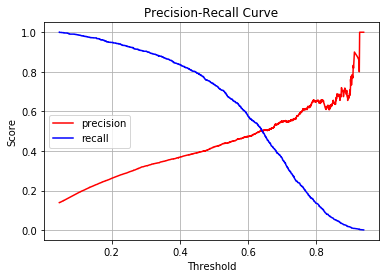

In [28]:
from sklearn.metrics import precision_recall_curve
y_prob = model.predict_proba(X_test_prep)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.plot(thresholds, precision[:-1], label='precision',color='r')
plt.plot(thresholds, recall[:-1], label='recall',color='b')
plt.title('Precision-Recall Curve')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
threshold = 0.44
predicted_proba = model.predict_proba(X_test_prep)
predicted = (predicted_proba [:,1] >= threshold).astype('int')
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90      7934
           1       0.39      0.80      0.52      1051

    accuracy                           0.83      8985
   macro avg       0.68      0.82      0.71      8985
weighted avg       0.90      0.83      0.85      8985

[[6595 1339]
 [ 207  844]]


In [81]:
import pickle

In [82]:
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)



In [84]:
threshold = 0.45

model_data = {
    'model': model,
    'threshold': threshold
}

filename = 'RFC3.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model_data,file)